In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("comments") \
    .config("spark.dynamicAllocation.executorIdleTimeout", "300s")\
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "2") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from pyspark.sql.functions import col
import pyspark.sql.functions as F

from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import desc
from pyspark.sql.functions import year, count
from pyspark.sql.functions import round
from pyspark.sql.types import StructType, StructField, IntegerType
from collections import Counter

from wordcloud import WordCloud
from collections import ChainMap
import pyspark.sql.functions as F

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# reading in data
data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .load("s3://131313113finalproject/output_fixed.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
data = data.withColumn('date_posted', to_timestamp(data['date_posted']))

print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()
data.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 7
Total Rows: 10372
root
 |-- title: string (nullable = true)
 |-- date_posted: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- flare: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- url: string (nullable = true)

DataFrame[title: string, date_posted: timestamp, author: string, id: string, flare: string, num_comments: string, url: string]

In [10]:
# checking to see stopwords
stopwords = StopWordsCleaner().getStopWords()

# adding abortion, bc its mentioned in every title and might throw off model
stopwords.append("abortion")
stopwords.append('abortions')
stopwords.append('im')


# PIPELINE
# creating new col
document_assembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# transforming col
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# taking out stop words
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("stopworded")\
      .setStopWords(stopwords) \
      .setCaseSensitive(False)

# normalizing col
normalizer = Normalizer() \
    .setInputCols(["stopworded"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# finishing
finisher = Finisher() \
    .setInputCols(["normalized"]) \
    .setOutputCols(["tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            stopwords_cleaner,
            normalizer, 
            finisher])

nlp_model = nlp_pipeline.fit(data)
processed_df  = nlp_model.transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Word Clouds

I thought it would be interesting to see if/how the terminology or conversation surrounding abortion changes from year to year. I think the best way to visualize this is through wordclouds.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

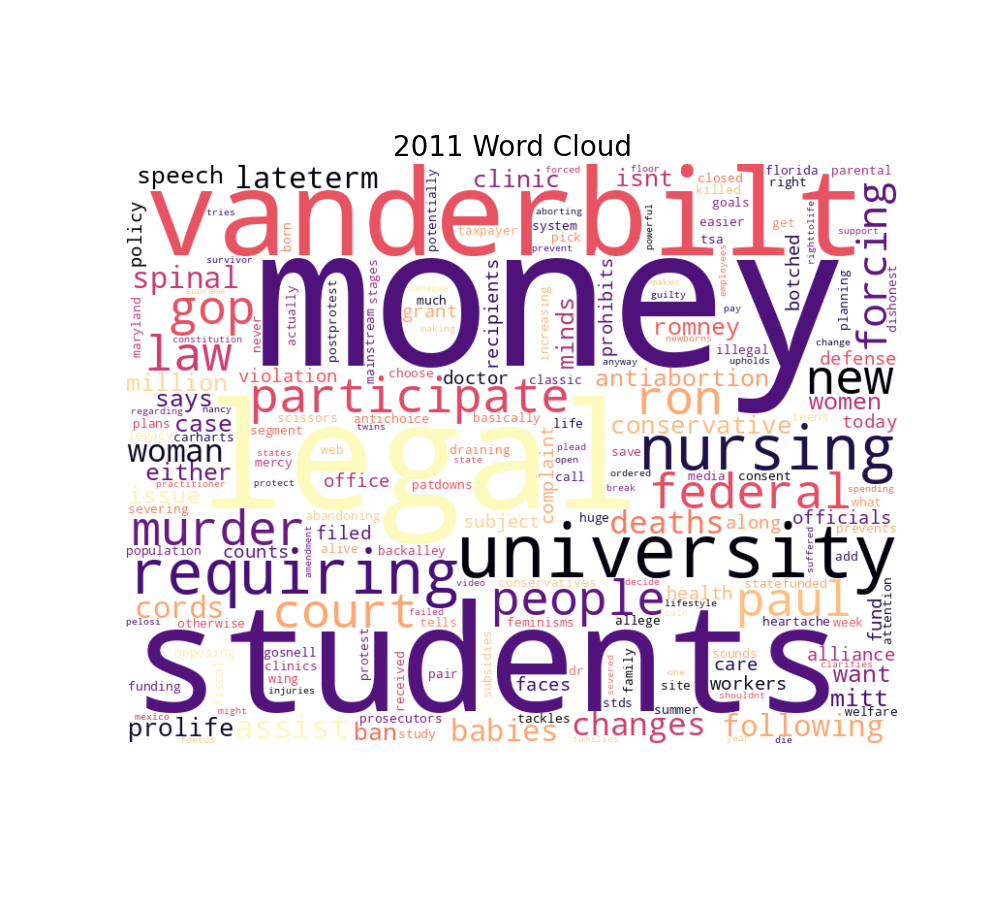

In [12]:
# 2011
year = 2011

def word_clouds(year):
    posts = processed_df.filter(F.year(processed_df['date_posted']) == year)
    word_cloud_str = posts.withColumn('tokens_s', F.concat_ws(' ', 'tokens'))
    all_tokens_str = ' '.join([row.tokens_s for row in word_cloud_str.select('tokens_s').collect()])

    word_counts = Counter(all_tokens_str.split())
    max_freq = max(word_counts.values())
    normalized_word_freqs = {word: freq / max_freq for word, freq in word_counts.items()}

    wordcloud = WordCloud(background_color="white", colormap = 'magma', width=800, height=600)
    wordcloud.generate_from_frequencies(normalized_word_freqs)

    plt.figure(figsize=(10, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{year} Word Cloud', fontsize=20)
    plt.axis("off")
    return plt

plt = word_clouds(2011)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

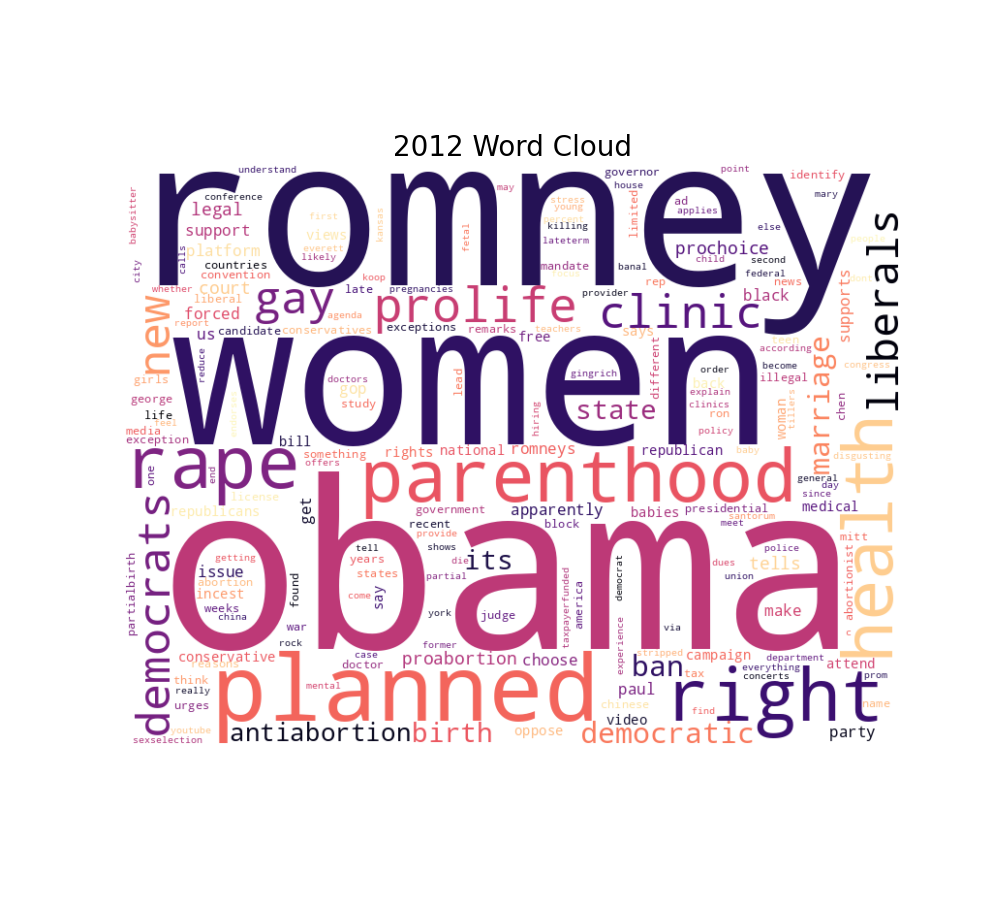

In [13]:
plt = word_clouds(2012)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

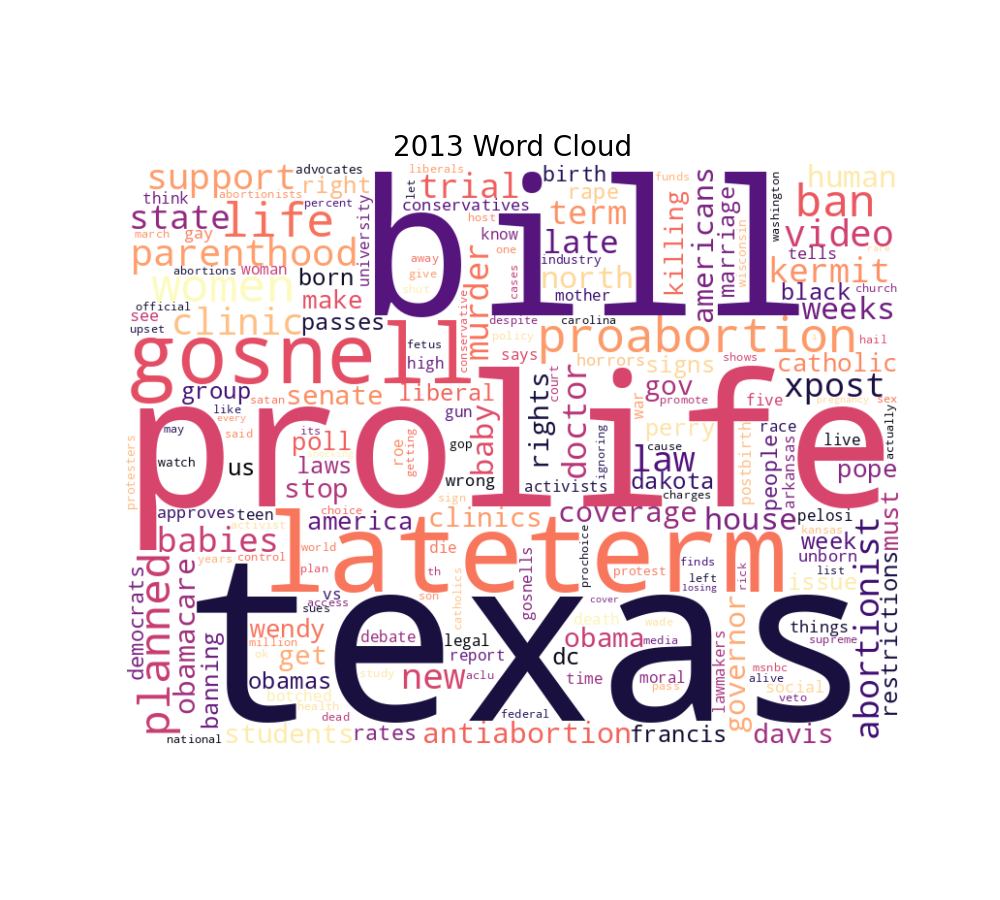

In [14]:
plt = word_clouds(2013)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

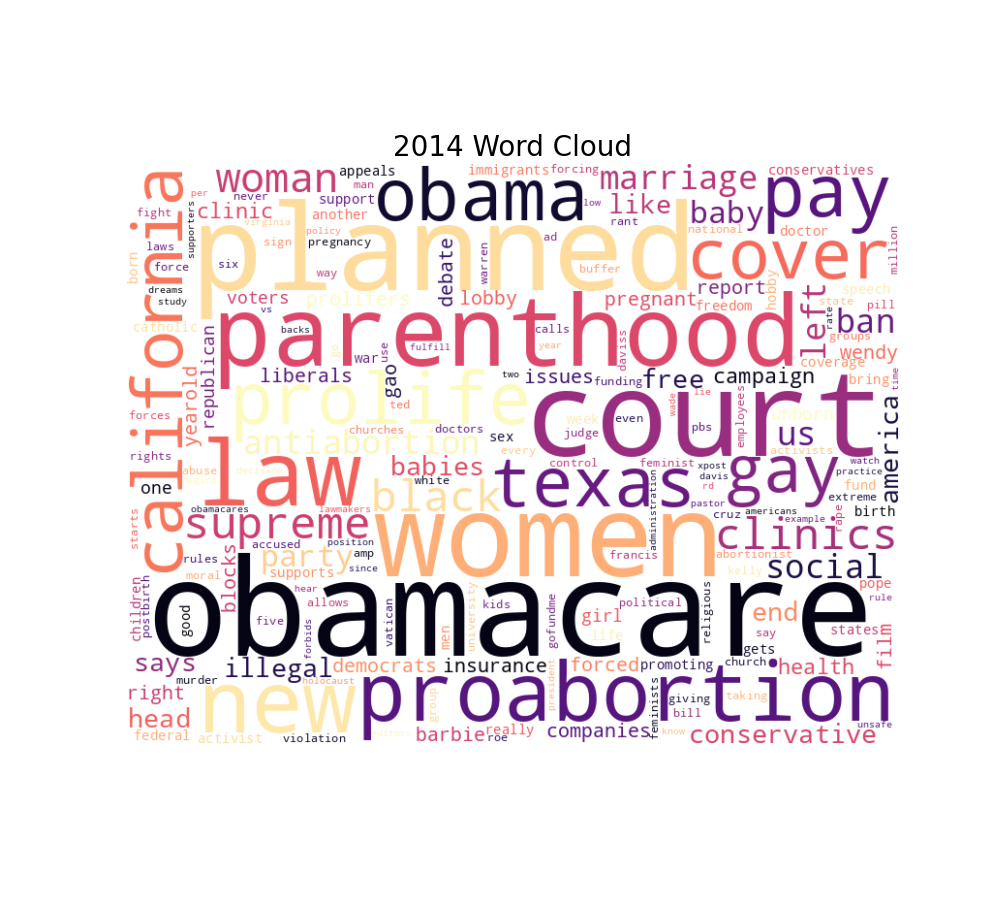

In [15]:
plt = word_clouds(2014)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

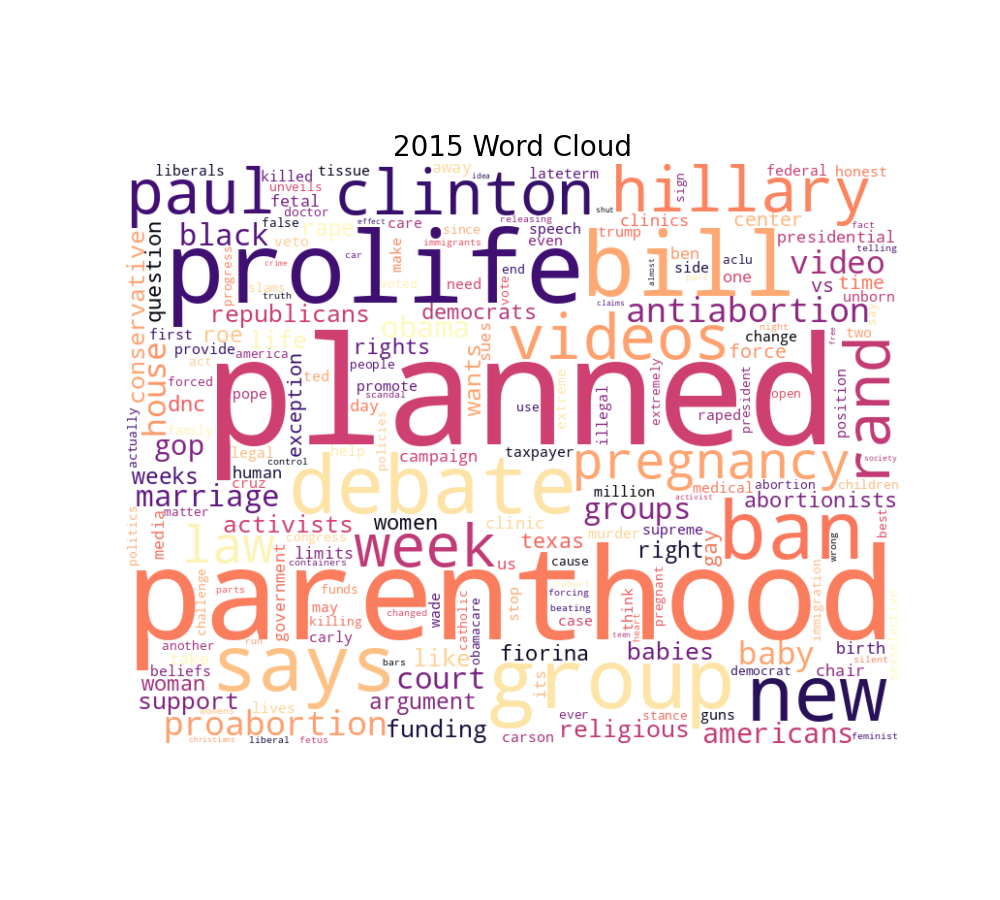

In [16]:
plt = word_clouds(2015)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

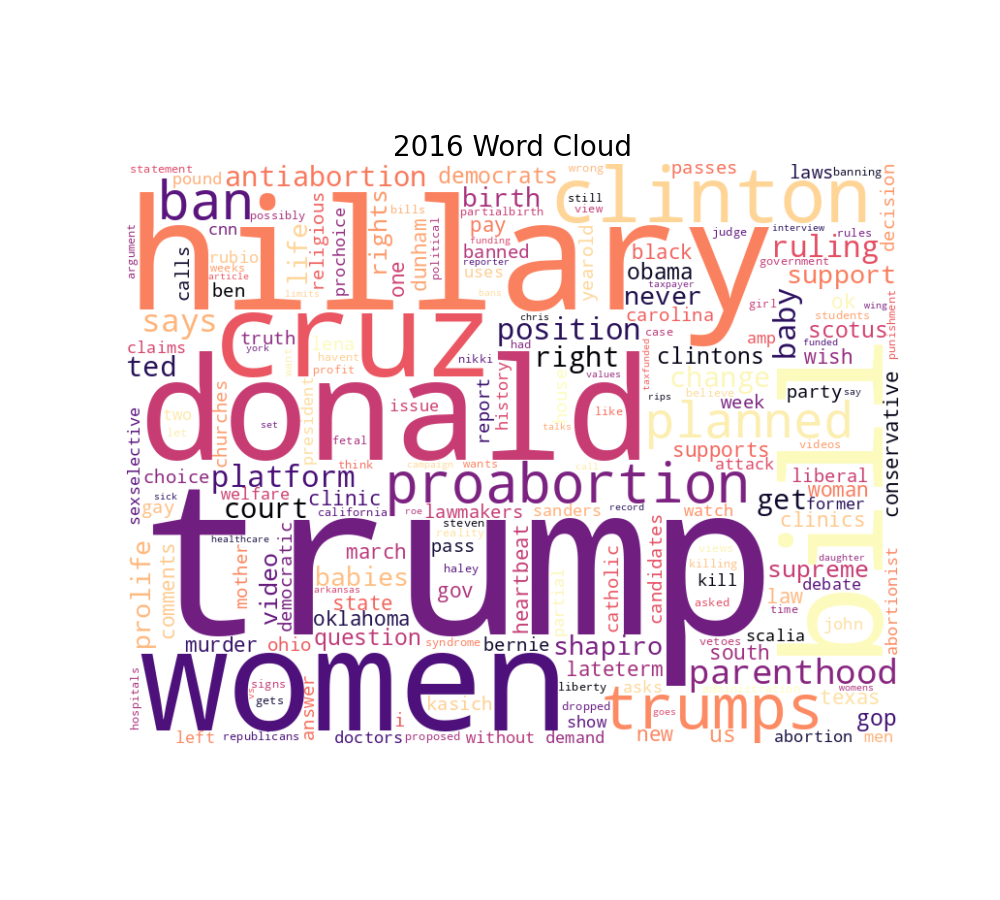

In [17]:
plt = word_clouds(2016)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

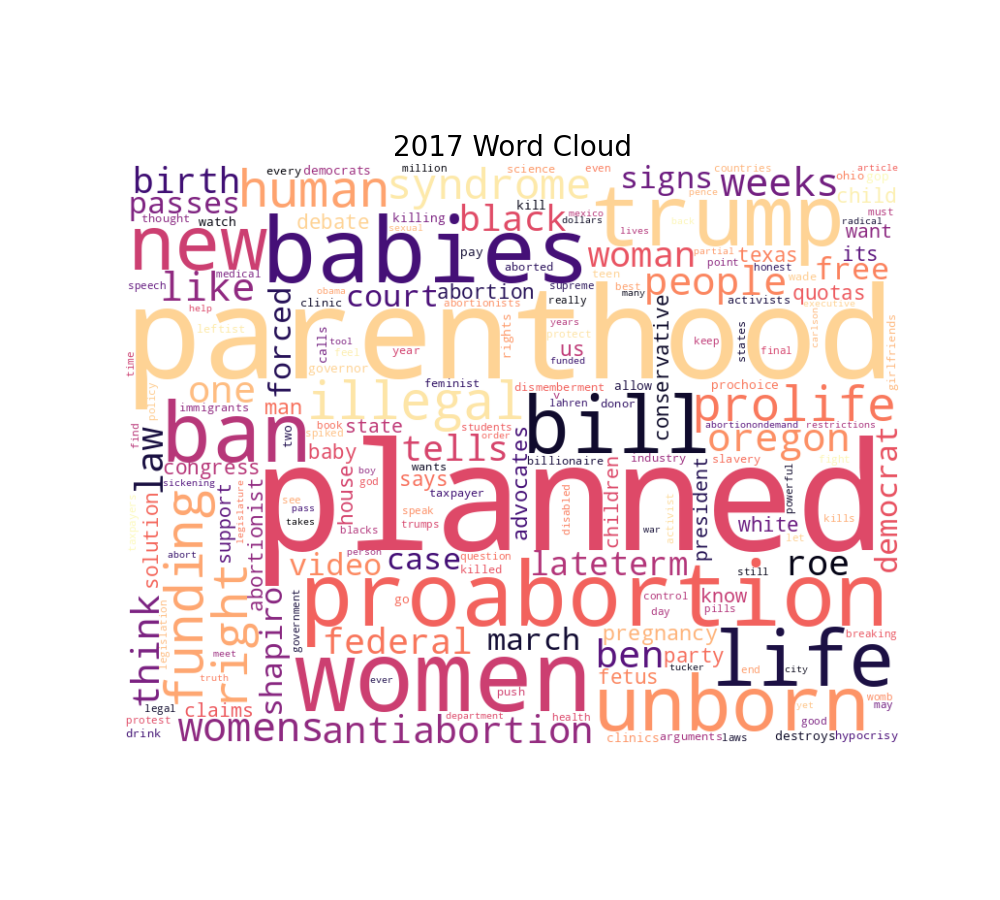

In [18]:
plt = word_clouds(2017)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

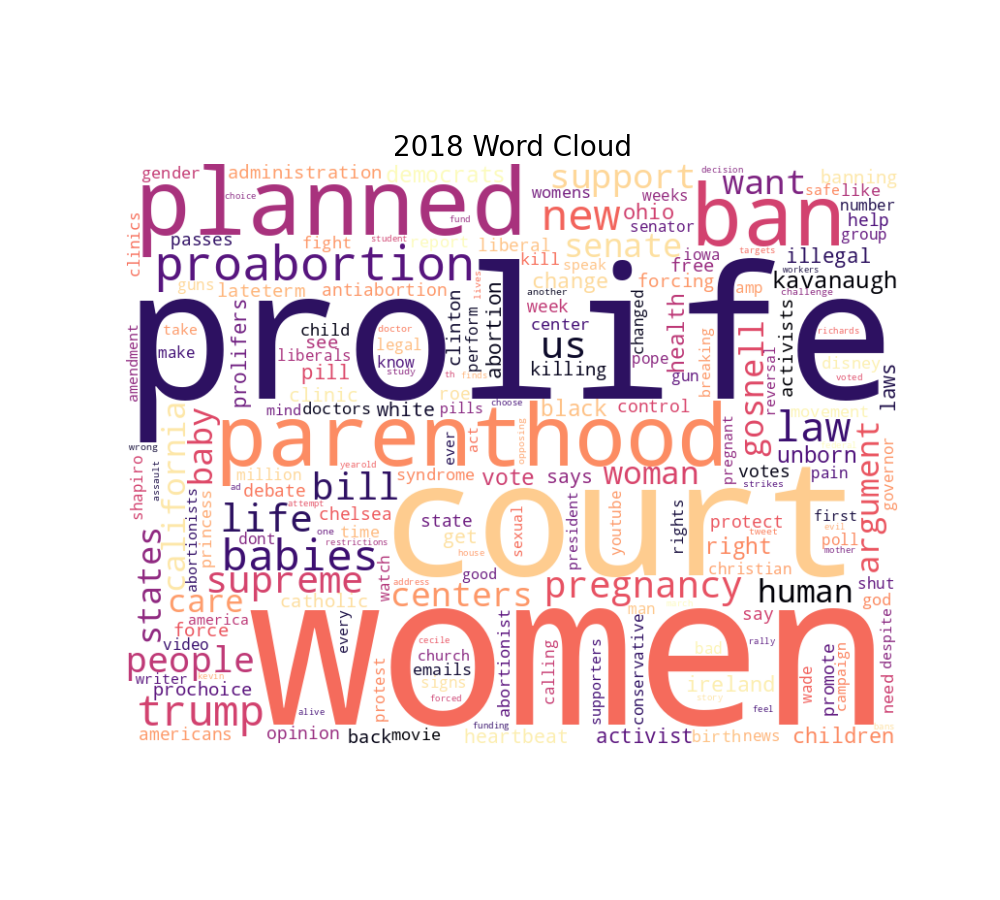

In [19]:
plt = word_clouds(2018)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

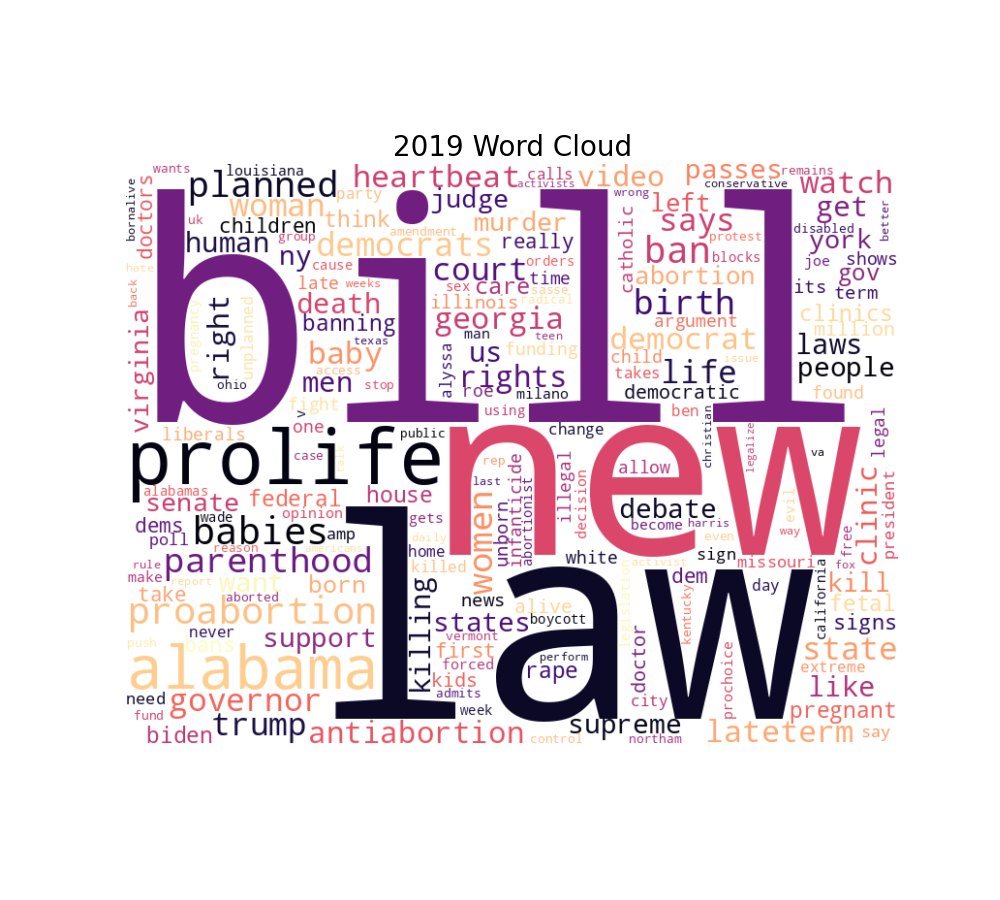

In [20]:
plt = word_clouds(2019)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

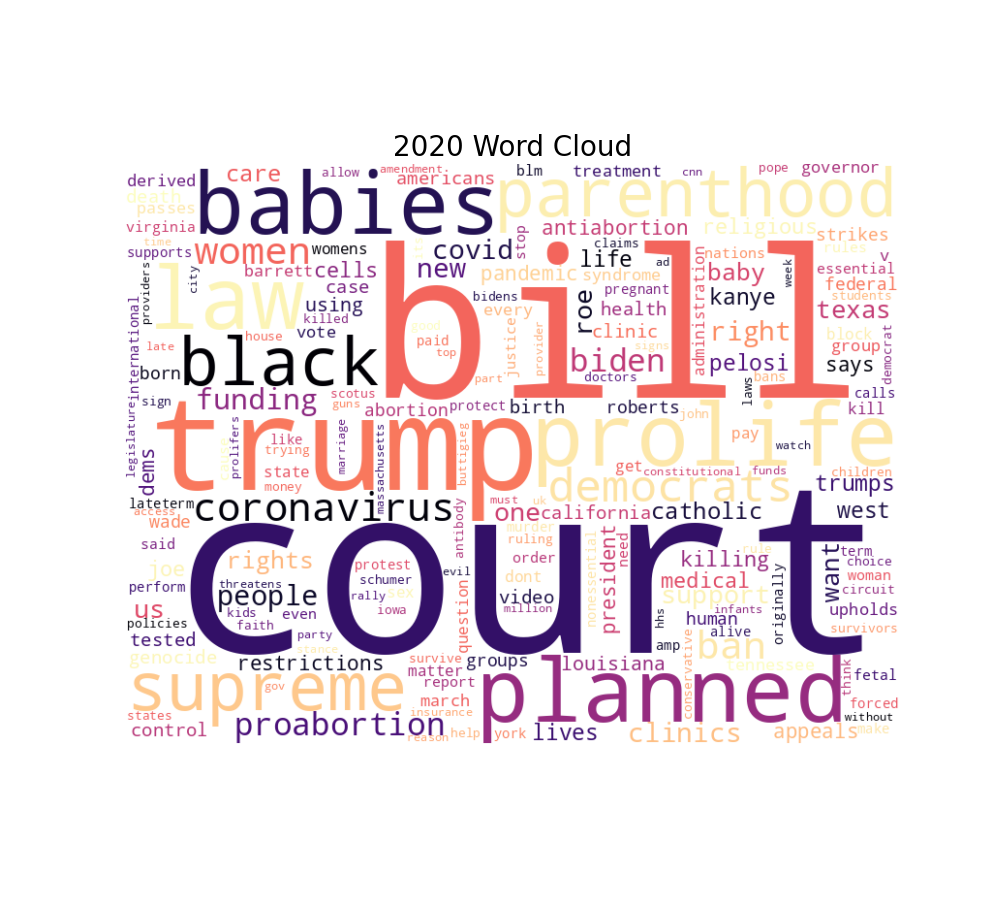

In [21]:
plt = word_clouds(2020)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

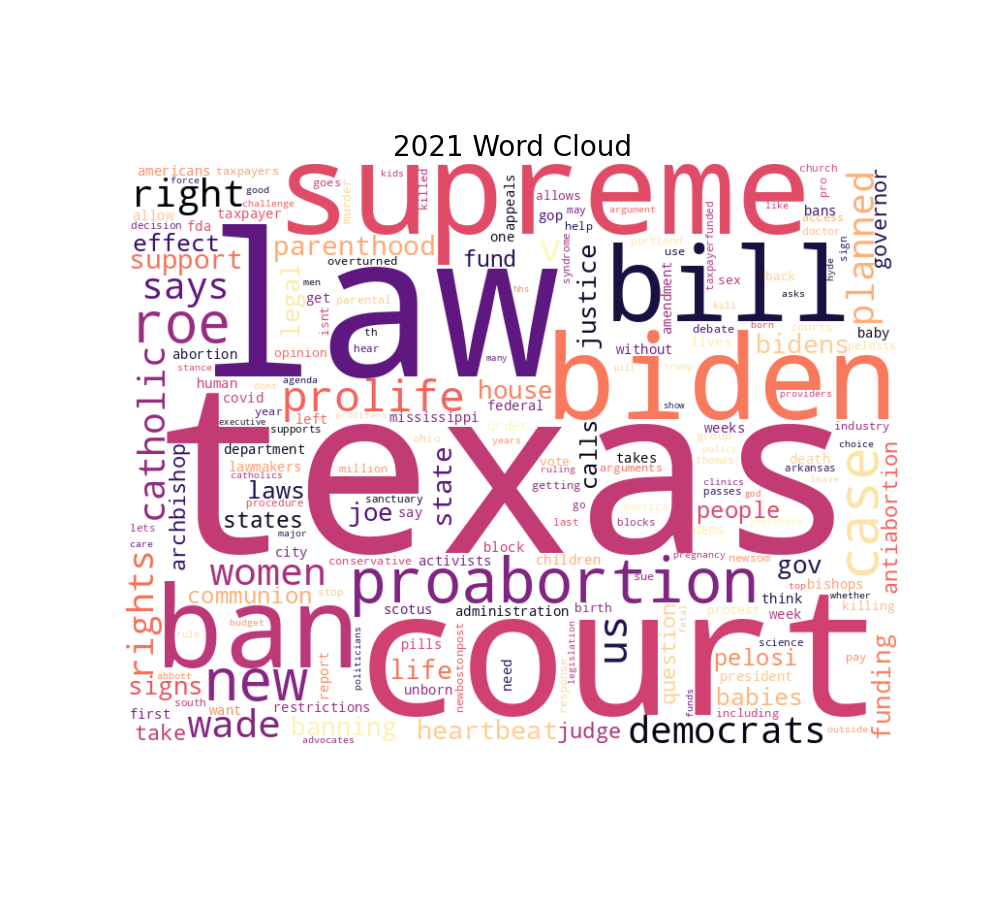

In [22]:
plt = word_clouds(2021)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

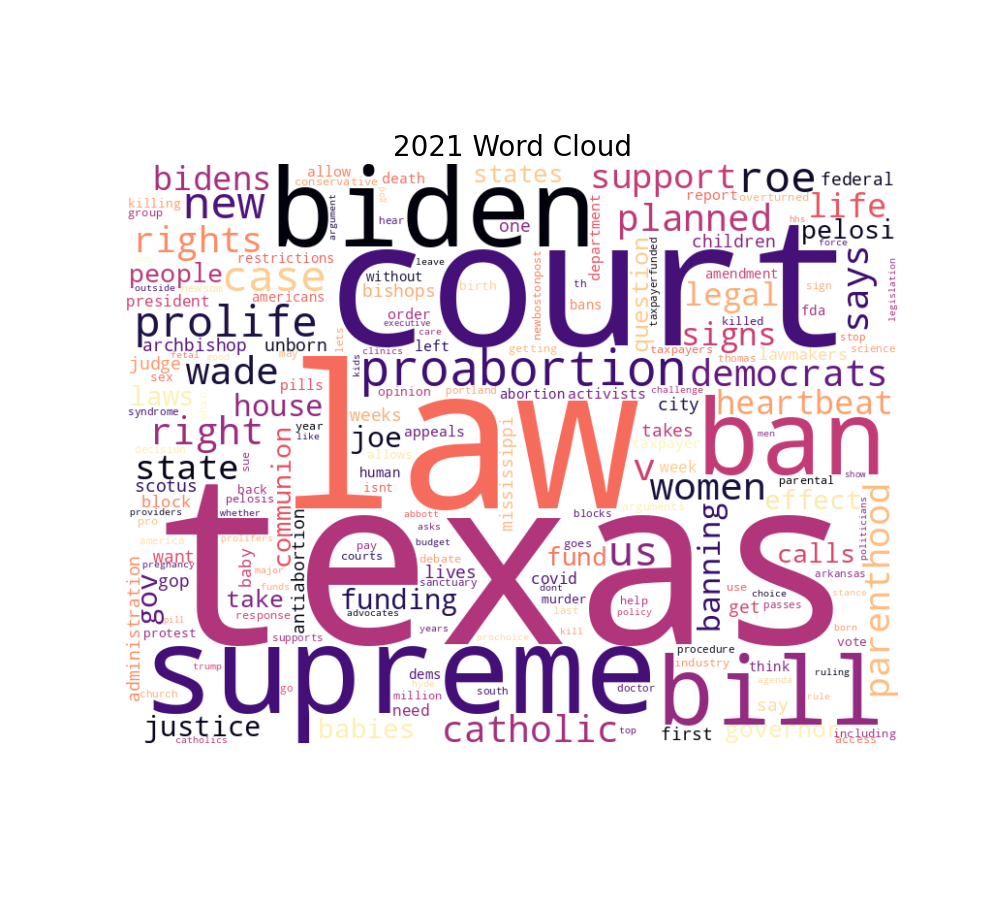

In [19]:
plt = word_clouds(2021)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

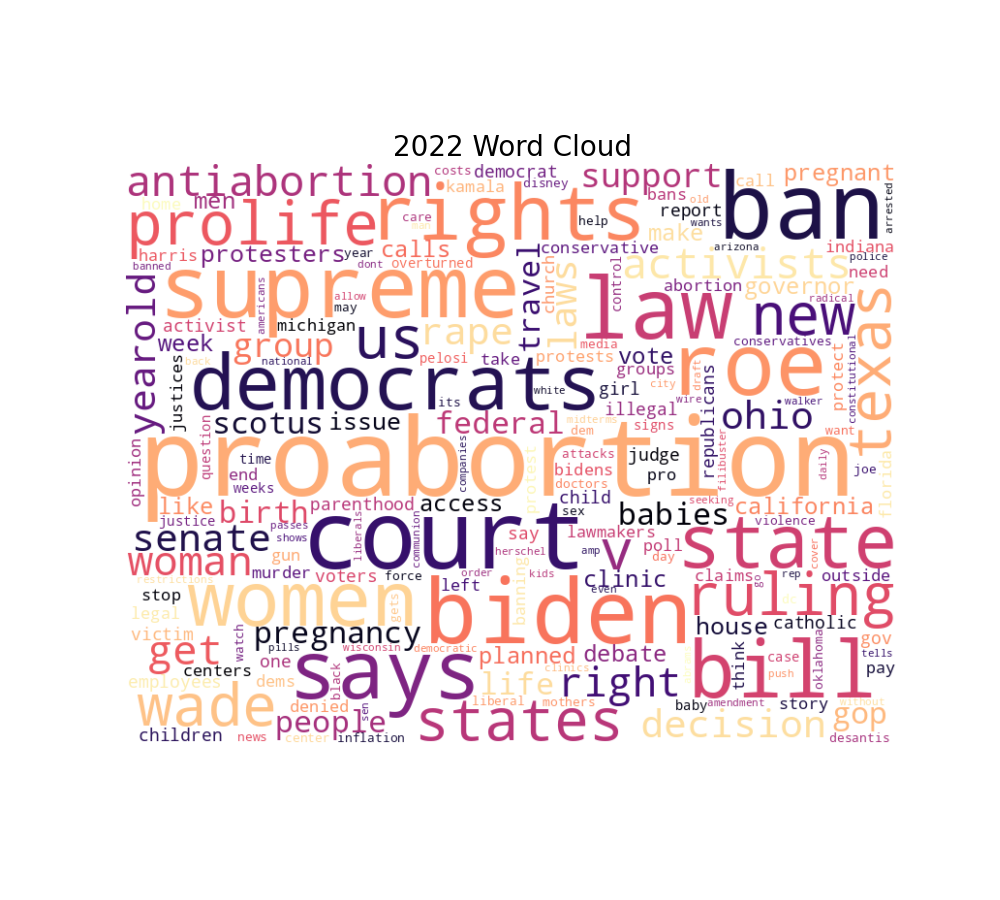

In [20]:
plt = word_clouds(2022)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

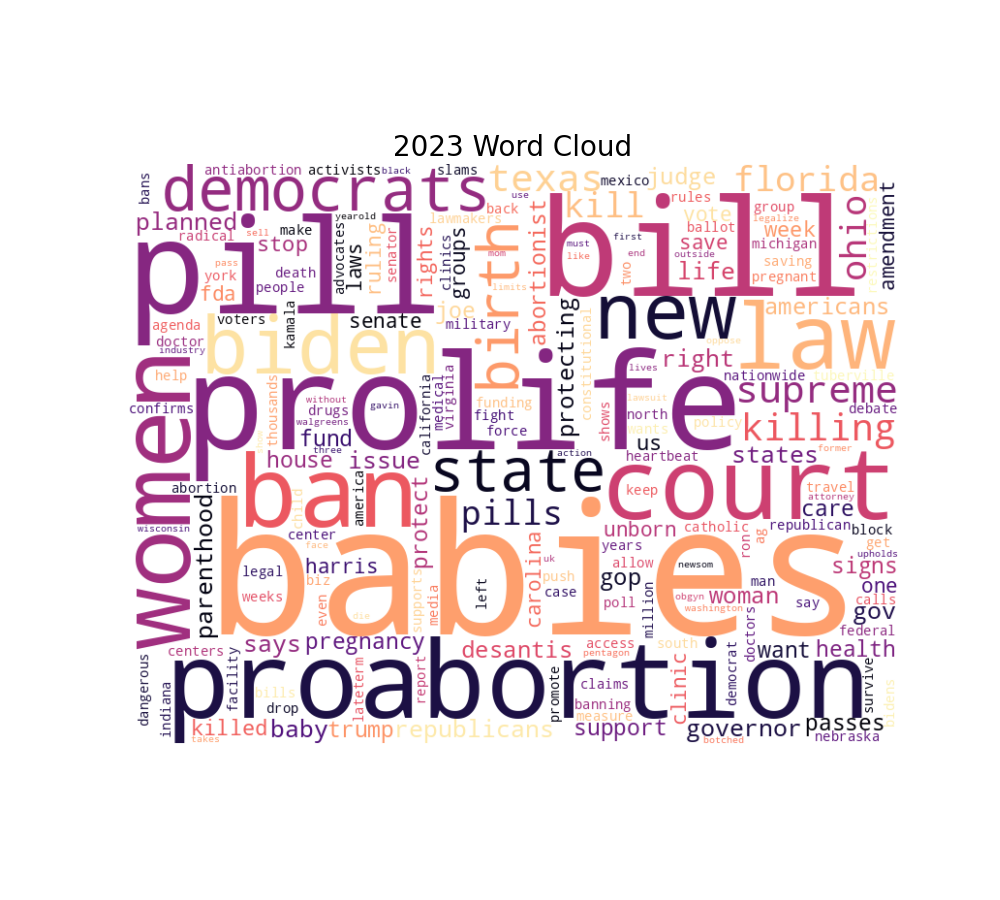

In [21]:
plt = word_clouds(2023)
%matplot plt